In [1]:
import yfinance as yf
ticker = "AAPL"
stock_data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2018-01-02  40.524342  43.064999  43.075001  42.314999  42.540001  102223600
2018-01-03  40.517292  43.057499  43.637501  42.990002  43.132500  118071600
2018-01-04  40.705490  43.257500  43.367500  43.020000  43.134998   89738400
2018-01-05  41.168934  43.750000  43.842499  43.262501  43.360001   94640000
2018-01-08  41.016022  43.587502  43.902500  43.482498  43.587502   82271200


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Focus on the 'Close' price
data = stock_data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare the data for training
X = []
y = []

# Use the last 60 days' closing prices to predict the next day's closing price
for i in range(60, len(data_scaled)):
    X.append(data_scaled[i-60:i, 0])  # Last 60 days
    y.append(data_scaled[i, 0])  # Next day's closing price

X = np.array(X)
y = np.array(y)

# Reshape X to be in 3D (samples, time steps, features) for LSTM or 2D for other models
X = X.reshape(X.shape[0], X.shape[1], 1)  # For LSTM

# Split into training and testing datasets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)


(1159, 60, 1) (290, 60, 1)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Reshape X to 2D for Linear Regression
X_train_lr = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_lr = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Initialize and train the model
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test_lr)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error (Linear Regression): {mse}")


Mean Squared Error (Linear Regression): 0.00025851095424320793


In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))  # Output layer

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"Mean Squared Error (LSTM): {mse_lstm}")


ModuleNotFoundError: No module named 'tensorflow'

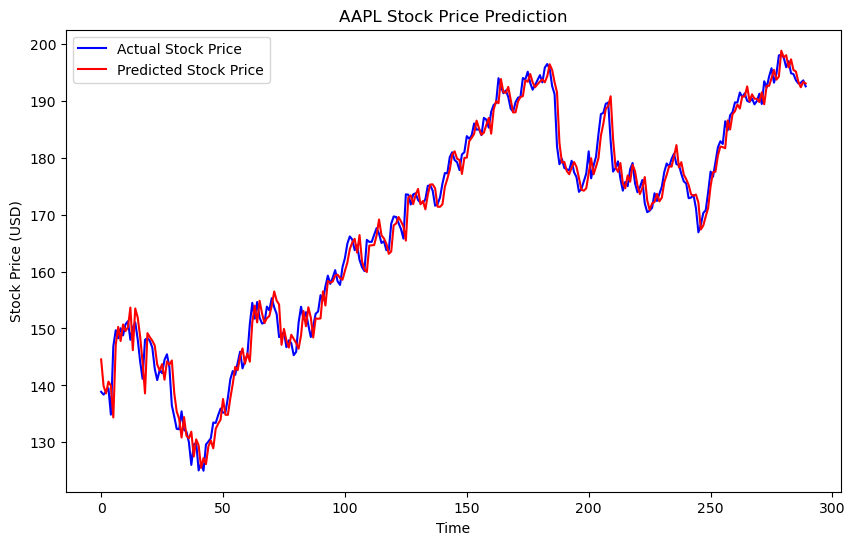

In [11]:
import matplotlib.pyplot as plt

# Inverse scaling for visualization
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_lr.reshape(-1, 1))  # For Linear Regression
# y_pred_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))  # For LSTM

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, color='blue', label='Actual Stock Price')
plt.plot(y_pred_inv, color='red', label='Predicted Stock Price')
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()
